<a href="https://colab.research.google.com/github/jeonggunlee/DeepLearningBasics/blob/master/Lab09_MEDICAL/Blood_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 딥러닝을 이용한 Blood Cell Classification (혈구 분류)
- LYMPHOCYTE (림프구), NEUTROPHIL (호중구), MONOCYTE (단핵구), 'EOSINOPHIL (호산구) 분류
- 세부 설명
   - 호중구: 호중구는 단엽성 핵이자 원형세포로서 크고 불규칙하며 진한 파란색 과립이 원형질에 존재한다.
   - 호산구: 호산구는 이엽성 핵이자 원형세포로서 크기가 일정한 거칠고 진한 빨간색 과립이 원형질에 존재한다.
   - 림프구: 림프구는 크기가 크고 둥근 핵이자 원형 세포이다.
   - 단핵구: 단핵구는 원형이거나 단엽성 핵이며, 콩팥 모양의 큰 원형 세포이다.

참조: https://ko.wikipedia.org/wiki/백혈구


학습을 위한 주의: 학습을 위해서 GPU를 사용해야함
- 상단 바에 런타임 클릭
- 런타임 유형변경 클릭
- GPU 선택

In [44]:
!pwd

/content


In [45]:
!pip install kaggle

Kaggle에 등록후 ```.kaggle.json``` 화일을 upload합니다.

- Upload 방법
   - www.kaggle.com 방문하여, registration 완료
   - Profile > Account tab > Create API Token 클릭 => kaggle.json 다운로드
   - Colab [파일]메뉴의 [업로드]를 이용하여 kaggle.json 화일을 colab환경으로 upload

In [46]:
!ls

blood-cells.zip  dataset2-master  dataset-master  kaggle.json  sample_data


In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [50]:
!kaggle datasets download -d paultimothymooney/blood-cells

blood-cells.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
!unzip blood-cells.zip

Archive:  blood-cells.zip
replace dataset-master/dataset-master/Annotations/BloodImage_00000.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00000.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00001.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00002.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00003.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00004.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00005.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00006.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00007.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00008.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00009.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00010.xml  
  in

# DataSets

- 용어
   - RBC : Red Blood Cell
   - WBC : White Blood Cell
   - NEUTROPHIL : 호중구
   - EOSINOPHIL : 호산구
   - MONOCYTE : 단핵구
   - LYMPHOCYTE : 림프구

---

## 파일구조 살펴보기

- dataset-master1
   - dataset-master1 폴더에는 Annotations, JPEGImages 폴더가 2개 있다. Annotations 에는 xml파일이 있다. bounding box로 물체를 검출하는데 사용할 데이터셋으로 판단된다.
   - xml 파일을 살펴볼때 RBC에 대한 bounding box만 존재한다.
   - 만약 object detection을 진행하려면 [이 곳](https://github.com/Shenggan/BCCD_Dataset/tree/master/BCCD)에서 데이터를 다시 받아야 한다.

- dataset-master2
   - dataset-master2 폴더에는 이미지가 각 클래스 별로 폴더에 나누어져 있다. 이미지를 분류하는 문제에서 사용할 데이터셋이 된다.
   - **실습은 분류문제를 해결하기 위해서 진행한다.**

In [0]:
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler

분류 문제를 위한 데이터 셋으로 사용할 이미지 데이터가 저장된 path를 설정

In [0]:
img_path = './dataset2-master/dataset2-master/images'

이미지 데이터가 저장된 Top directory이 하부 디렉토리 구조를 살펴보자.

- TRAIN: 학습에 사용할 이미지 데이터가 저장된 directory
- TEST: Validation 및 Accuracy 확인용
- TEST_SIMPLE: 단일 이미지 데이터 test용


In [54]:
os.listdir(img_path)

['TEST_SIMPLE', 'TEST', 'TRAIN']

In [0]:
train_img_path = os.path.join(img_path, 'TRAIN')
test_img_path = os.path.join(img_path, 'TEST')
test_simple_img_path = os.path.join(img_path,'TEST_SIMPLE')

Train 이미지 디렉토리와 Test 이미지 디렉토리 하부에는 각 혈구의 종류별로 디렉토리가 구성되어 있으며, 각 디렉토리에 해당 이미지가 저장되어 있다.

In [56]:
classes = os.listdir(train_img_path)
print('classes : ', classes)

classes :  ['MONOCYTE', 'LYMPHOCYTE', 'NEUTROPHIL', 'EOSINOPHIL']


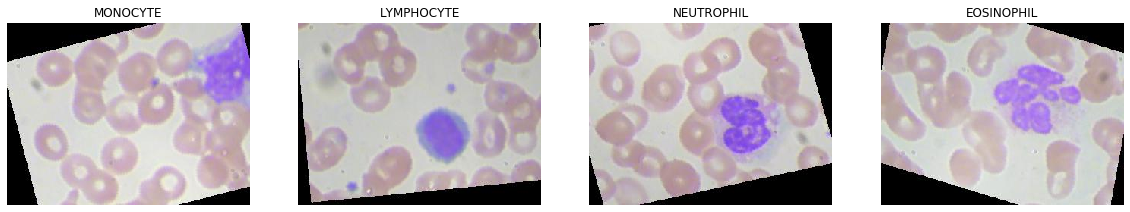

In [94]:
plt.figure(figsize=(20,20))

for i,cls in enumerate(classes):
    # 0, MONOCYTE
    # 1, LYMPHOCYTE
    # 2, NEUTROPHIL
    # 3, EOSINOPHIL
    plt.subplot(1, 4, i+1)  # 1X5 subplot을 구성하며, 3번째 인자는 순서를 의미
    plt.title(cls)
    plt.axis('off')
    
    path=os.path.join(train_img_path, cls)  # 각 class의 패스에서
    img_path=os.listdir(path)[0]            # 첫번째 이미지의 이름을 가져옮
    img = cv2.imread(os.path.join(path, img_path)) # path + image_path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 컬러 사진을 OpenCV에서는 BGR 순서로 저장하는데 matplotlib에서는 RGB 순서로 저장
    
    plt.imshow(img)

# Hyperparameter

In [0]:
image_shape=[128,128,3]
batch_size=64
epochs=50
lr=0.1

# Model: SqueezeNet

SqueezeNet (2016)
   - Up to this point, research focused on improving the accuracy of neural networks, the SqueezeNet team took the path of designing smaller models while maintaining the accuracy unchanged.
   - It resulted into SqueezeNet, which is a convolutional neural network architecture that has 50 times fewer parameters than AlexNet while maintaining its accuracy on ImageNet.

![SqueezeNet](http://christopher5106.github.io/img/deeplearningcourse/DL46.jpg)
[참조] http://christopher5106.github.io/deep/learning/2018/10/20/course-two-build-deep-learning-networks.html


In [0]:
"""
model reference : https://www.kaggle.com/drobchak1988/blood-cell-images-acc-92-val-acc-90
"""
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D


bnmomemtum=0.85
def fire(x, squeeze, expand):  # x: 입력, squeeze, expand: 모델 파라미터
    y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y  = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = Input(shape=image_shape)
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(4, activation='softmax')(y)

위 모델에서 가장 마지막 레이어의 뉴런의 수를 확인하세요! 4!!!

In [60]:
from keras.models import Model

model = Model(x, y)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 12) 912         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 128, 128, 12) 48          conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 12) 156         batch_normalization_42[0][0]     
____________________________________________________________________________________________



---


옵티마이저 설정

In [0]:
adam = Adam(lr=lr, decay=0.0001)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
train_generator = ImageDataGenerator(
        rescale=1./255,
)

test_generator = ImageDataGenerator(
        rescale=1./255,
)

In [70]:
train_data = train_generator.flow_from_directory(train_img_path,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 target_size=(image_shape[0], image_shape[1]),
                                                 shuffle=True,
                                                 class_mode = "categorical")

test_data = test_generator.flow_from_directory(test_img_path,
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                target_size=(image_shape[0], image_shape[1]),
                                                shuffle=True,
                                                class_mode = "categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.




---
Callback 함수 설정


In [0]:
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate=LearningRateScheduler(step_decay)

In [72]:
# learning rate의 변화 살펴보기
initial_lrate = 0.1
drop = 0.5
epochs_drop = 10.0
epoch_test = 1
lrate_test = initial_lrate * math.pow(drop, math.floor((1+epoch_test)/epochs_drop))
print(lrate)

epoch_test = 10
lrate_test = initial_lrate * math.pow(drop, math.floor((1+epoch_test)/epochs_drop))
print(lrate_test)

epoch_test = 20
lrate_test = initial_lrate * math.pow(drop, math.floor((1+epoch_test)/epochs_drop))
print(lrate_test)

0.05
0.025


# Train

In [73]:
history = model.fit_generator(train_data, 
                              steps_per_epoch=train_data.n // train_data.batch_size, 
                              epochs=epochs, 
                              validation_data=test_data,
                              validation_steps=test_data.n // test_data.batch_size,
                              callbacks=[lrate])

Epoch 1/50
155/155 [==============================] - 24s 155ms/step - loss: 0.8222 - acc: 0.6233 - val_loss: 12.0918 - val_acc: 0.2496
Epoch 2/50
155/155 [==============================] - 19s 120ms/step - loss: 0.4699 - acc: 0.7997 - val_loss: 6.4741 - val_acc: 0.3586
Epoch 3/50
155/155 [==============================] - 19s 120ms/step - loss: 0.4045 - acc: 0.8343 - val_loss: 1.0128 - val_acc: 0.6620
Epoch 4/50
155/155 [==============================] - 19s 121ms/step - loss: 0.2817 - acc: 0.8869 - val_loss: 7.5791 - val_acc: 0.2518
Epoch 5/50
155/155 [==============================] - 19s 120ms/step - loss: 0.2530 - acc: 0.8983 - val_loss: 10.2614 - val_acc: 0.2357
Epoch 6/50
155/155 [==============================] - 19s 120ms/step - loss: 0.2156 - acc: 0.9184 - val_loss: 1.2718 - val_acc: 0.6913
Epoch 7/50
155/155 [==============================] - 18s 118ms/step - loss: 0.1936 - acc: 0.9229 - val_loss: 0.4942 - val_acc: 0.8362
Epoch 8/50
155/155 [==============================] -

# Graph

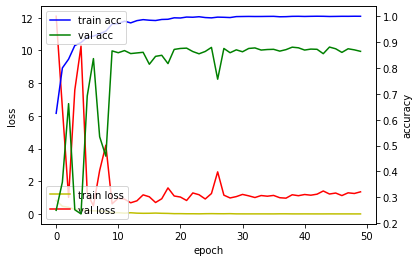

In [74]:
import matplotlib.pyplot as plt

fig, loss = plt.subplots()
acc = loss.twinx()  # x축 공유

loss.plot(history.history['loss'], 'y', label='train loss')
loss.plot(history.history['val_loss'], 'r', label='val loss')
loss.set_xlabel('epoch')
loss.set_ylabel('loss')
loss.legend(loc='lower left')

acc.plot(history.history['acc'], 'b', label='train acc')
acc.plot(history.history['val_acc'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='upper left')

plt.show()

---
# Test
loss, accuracy = model.evaluate_generator

In [75]:
model.evaluate_generator(test_data, steps=test_data.n // test_data.batch_size)

[1.2924463223469884, 0.8704769736842105]

---
학습된 model weight save: save_weights
학습된 model weight load: load_weigths


In [0]:
model.save_weights("model.h5")

In [0]:
model.load_weights("model.h5")

# Explainable Deep Learning
- CAM(Class Activation Mapping)

# reference

- [https://github.com/jacobgil/keras-cam](https://github.com/jacobgil/keras-cam)

In [0]:
# 마지막 layer의 weight 가져오기
class_weights = model.layers[-1].get_weights()[0]

# 모델의 모든 레이어 및 이름으로 이루어진 pair (이름, layer)에 대한 dictionary 구성
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [79]:
layer_dict

{'batch_normalization_42': <keras.layers.normalization.BatchNormalization at 0x7f95edf24208>,
 'batch_normalization_43': <keras.layers.normalization.BatchNormalization at 0x7f95ede65a20>,
 'batch_normalization_44': <keras.layers.normalization.BatchNormalization at 0x7f95ede2da20>,
 'batch_normalization_45': <keras.layers.normalization.BatchNormalization at 0x7f95eddf39e8>,
 'batch_normalization_46': <keras.layers.normalization.BatchNormalization at 0x7f95edd41d68>,
 'batch_normalization_47': <keras.layers.normalization.BatchNormalization at 0x7f95edd00f60>,
 'batch_normalization_48': <keras.layers.normalization.BatchNormalization at 0x7f95edcc9f60>,
 'batch_normalization_49': <keras.layers.normalization.BatchNormalization at 0x7f95edca0390>,
 'batch_normalization_50': <keras.layers.normalization.BatchNormalization at 0x7f95edc5f588>,
 'batch_normalization_51': <keras.layers.normalization.BatchNormalization at 0x7f95edc24588>,
 'batch_normalization_52': <keras.layers.normalization.Batch

In [81]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 12) 912         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 128, 128, 12) 48          conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 12) 156         batch_normalization_42[0][0]     
____________________________________________________________________________________________

마지막 activation map 가져오기

In [0]:
final_conv = layer_dict['concatenate_18']

In [0]:
import keras.backend as K

get_output = K.function([model.layers[0].input], [final_conv.output, model.layers[-1].output])

In [0]:
img_path = os.path.join(test_simple_img_path ,'MONOCYTE//_1_4511.jpeg')

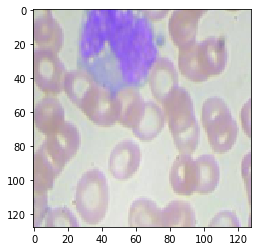

In [120]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

plt.imshow(img)

In [121]:
[conv_outputs, predictions] = get_output([[img / 255.0]]) # K_function
print(predictions)

[[2.6182353e-17 2.1936793e-14 1.0000000e+00 1.0541083e-17]]


In [0]:
conv_outputs = conv_outputs[0, ...]  # 배치 제외, W-H-C
conv_outputs = np.transpose(np.float32(conv_outputs), (2,0,1)) # C-W-H

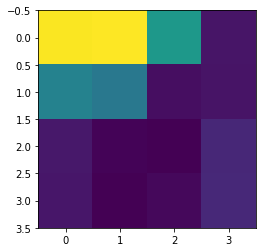

In [123]:
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3]) # W-H

for i, w in enumerate(class_weights[:, 2]): # 2: class num
    cam += w * conv_outputs[i, :, :]

cam = cam - np.min(cam)
cam /= np.max(cam)
plt.imshow(cam)

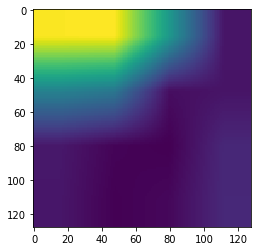

In [124]:
cam = cv2.resize(cam, (128, 128))
plt.imshow(cam)

In [125]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.2)] = 0
img = heatmap*0.3 + img*0.7
cv2.imwrite('./cam.jpg', img)

True

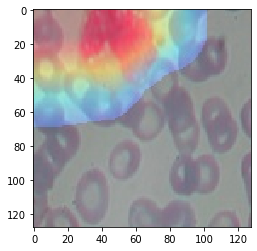

In [126]:
cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
plt.imshow(cam_img)



---
- VGG16 모델에서 90% 달성: https://eremo2002.tistory.com/55